In [1]:
import pandas as pd
import math
import collections
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class OtherKey:
    def __repr__(self):
        return 'OTHER'
OTHER = OtherKey()

# Node class
class Node:
    def __init__(self, attribute=None, children=None, classification=None):
        '''
        Intializer function
        Takes an attribute for the node, a dictionary of children nodes and a classification
        If it is a leaf node (no children) it will have a classification else None
        '''
        self.attribute = attribute
        self.classification = classification
        if children is None:
            self.children = {}
        else:
            self.children = children

    def classify(self, point):
        '''
        A function used to classify a point. Recursively calls until we reach a classification.
        Taken from a5.

        dict -> classification
        '''
        if self.classification is not None:
            return self.classification
        for child in self.children.keys():
            if point[self.attribute] == child:
                child_node = self.children[child]
                break
            else:
                child_node = self.children[OTHER]

        return child_node.classify(point)

    def train(self, data_points, labels):
        '''
        This will take a list of data points (each element is a dictionary which is a point)
        and a list of labels that goes with each point. Train the decision tree on these points
        and labels.

        taken from a5
        '''
        unique_labels, label_counts = unique(labels)
        if len(unique_labels) == 1:
            self.classification = unique_labels[0]
            return
        
        best_attr = None
        best_vals = None
        best_points_by_val = None
        best_labels_by_val = None
        best_ig = None
        
        for attribute in data_points[0].keys():
            vals = set()
            points_by_val = {}
            labels_by_val = {}
            val_freqs = {}
            for point, label in zip(data_points, labels):
                val = point[attribute]

                if not val in vals:
                    vals.add(val)
                    val_freqs[val] = 0
                    points_by_val[val] = []
                    labels_by_val[val] = []

                val_freqs[val] += 1
                points_by_val[val].append(point)
                labels_by_val[val].append(label)

            least_frequent = min(vals, key=val_freqs.get)

            vals.remove(least_frequent)
            vals.add(OTHER)
            points_by_val[OTHER] = points_by_val.pop(least_frequent)
            labels_by_val[OTHER] = labels_by_val.pop(least_frequent)
            val_freqs[OTHER] = val_freqs.pop(least_frequent)

            information_gain = info_gain(labels, labels_by_val, val_freqs)

            if best_attr is None or information_gain > best_ig:
                best_attr = attribute
                best_vals = vals
                best_points_by_val = points_by_val
                best_labels_by_val = labels_by_val
                best_ig = information_gain

        # what if all of the points are the same?
        if len(best_vals) == 1:
            _, self.classification = max(zip(label_counts, unique_labels))
            return

        self.attribute = best_attr
        for val in best_vals:
            child = Node()
            child.train(best_points_by_val[val], best_labels_by_val[val])
            self.children[val] = child

def unique(iterable):
    items = list(iterable)
    unique_items = list(set(items))
    counts = [items.count(item) for item in unique_items]
    return unique_items, counts

# Entropy and information gain functions:
def entropy(classifications):
    '''
    Calculate the entropy of an attribute. Takes a list of classifications in the form of: 
    [1, 4, 3, 5, 5, 3, 2, 1, 7] where each element represents the classification
    Works on string classifications too, Ex. ['Top 10', 'Win', 'Top 3']

    Rounded to four decimal points

    list -> float
    '''
    freq = collections.Counter(classifications)
    denom = len(classifications)
    total = 0
    for _, value in freq.items():
        total -= (value / denom) * math.log2(value / denom)
    return round(total, 4)

def info_gain(parent_classifications, classifications_by_val, val_freqs):
    ''' 
    Calculates the information gain of an attribute. Classifications is a dictionary of attribute with 
    keys being a trait and values being the classifications. 
    Ex. Attribute = Top 10 percent fastest lap time?
        {'Yes' : [Top 5, Top 3, Top 10],
        'No' : [Top 15, Top 20, Top 10]}
    
    Parent entropy is the entropy value for the parent. Needed to calculate the information gain.
    
    The classifications dictionary should be the data of the parent node after being split by the attribute
    that the classification dictionary represents.

    Rounds to four decimal places.
                                                            
    dict, float -> float
    '''
    attribute_entropy = 0
    total = sum([item for item in val_freqs.values()])
    for att in classifications_by_val.keys():
        attribute_entropy += entropy(classifications_by_val[att]) * (val_freqs[att] / total)
    
    information_gain = entropy(parent_classifications) - attribute_entropy

    return information_gain


In [2]:
# getting data and training
data_dict = {}
constructors_dict = {}

# load constructor data
constructors = pd.read_csv('kaggle-data/archive/constructors.csv')
for index, row in constructors.iterrows():
    key = row['constructorId']
    constructors_dict[key] = row['nationality']

# getting results data
results = pd.read_csv('kaggle-data/archive/results.csv') # results data
results = results[results['grid'] != 0]
results = results.dropna()

for index, row in results.iterrows():
    key_tuple = (row['raceId'], row['driverId']) # tuple for key in data dictionary
    value_list = [row['raceId'], row['driverId']]
    
    # checking for classification
    if row['positionOrder'] == 1: # first place 
        classification = 'First'
    elif row['positionOrder'] <= 5: # top 5
        classification = 'Top 5'
    elif row['positionOrder'] <= 10: # top 10
        classification = 'Top 10'
    else:
        classification = 'Outside Top 10'

    # turn grid position into range
    if row['grid'] <= 3:
        grid = 'Front'
    elif row['grid'] <= 10:
        grid = 'Middle'
    else:
        grid = 'Back'

    value_list.append(grid)
    
    # get last 5 races
    driver_id = row['driverId']
    race_id = row['raceId']

    past_races = results[(results['driverId'] == driver_id) & 
                         (results['raceId'] < race_id)]

    # Sort descending so we get most recent first
    past_races = past_races.sort_values(by='raceId', ascending=False)

    past_positions = past_races['positionOrder'].head(5)

    if len(past_positions) == 5:
        avg_pos = past_positions.mean()
    else:
        avg_pos = None  # not enough history

    if avg_pos is not None:
        if avg_pos <= 5:
            average_finish = 'Great'
        elif avg_pos <= 10:
            average_finish = 'Good'
        elif avg_pos <= 15:
            average_finish = 'Average'
        else:
            average_finish = 'Bad'

        # get constructor (nationality) data
        construct = row['constructorId']
        nation = constructors_dict[construct]
        value_list.append(nation)
        value_list.append(average_finish)
        value_list.append(classification)

        data_dict[key_tuple] = value_list


''' 
One data point will be a dictionary like so
Ex. {'grid': grid position,
    'nationality': constructors nationality,
    'avg_finish': average finish}
'''

points = []
labels = []

test_points = []
target_labels = []

# get first 10000 entries for training set
# we want to use 2014 - 2023 for the training set and 2024 for the testing set
# the race id for first race of 2014 900 to 1120 for last race of 2023 (220 races)

for key, value in data_dict.items():
    point = {}

    # check if we have right raceIds
    if key[0] >= 900 and key[0] <= 1120:
        # raceId is for training set
        point['grid'] = value[2]
        point['nationality'] = value[3]
        point['avg_finish'] = value[4]
        label = value[5]
        points.append(point)
        labels.append(label)
    elif key[0] > 1120:
        # these raceIds are for testing set
        point['grid'] = value[2]
        point['nationality'] = value[3]
        point['avg_finish'] = value[4]
        label = value[5]
        test_points.append(point)
        target_labels.append(label)


tree = Node()
tree.train(points, labels)


Accuracy: 0.681917211328976
 Using 2014-2023 as training set and 2024 as testing set

Confusion Matrix:



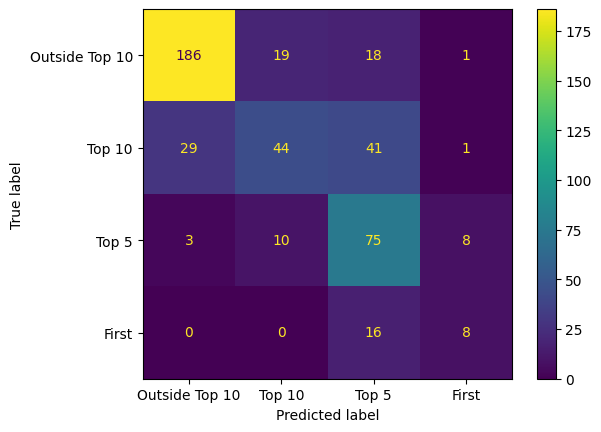

In [3]:
# Analyzing results
predictions = []
correct = 0
for point, label in zip(test_points, target_labels):
    prediction = tree.classify(point)
    predictions.append(prediction)
    if prediction == label:
        correct += 1

print(f'Accuracy: {correct/len(target_labels)}\n Using 2014-2023 as training set and 2024 as testing set')
print('\nConfusion Matrix:\n')
cm = confusion_matrix(target_labels, predictions, labels=['Outside Top 10', 'Top 10', 'Top 5', 'First'])
disp = ConfusionMatrixDisplay(cm, display_labels=['Outside Top 10', 'Top 10', 'Top 5', 'First'])
disp.plot()
plt.show()

In [ ]:
recent_data = {
               'Piastri': ['Front', 'Great', 'First'], 'Verstappen': ['Front', 'Great', 'Top 3'], 'Leclerc': ['Middle', 'Good', 'Top 3'],
               'Norris': ['Middle', 'Great', 'Top 5'], 'Russell': ['Front', 'Great', 'Top 5'], 'Antonelli': ['Middle', 'Good', 'Top 10'], 
               'Hamilton': ['Middle', 'Average', 'Top 10'], 'Sainz': ['Middle', 'Bad', 'Top 10'], 'Albon': ['Back', 'Good', 'Top 10'], 
               'Hadjar': ['Back', 'Average', 'Top 10'], 'Alonso': ['Back', 'Bad', 'Outside Top 10'], 'Lawson': ['Back', 'Bad', 'OUtside Top 10'], 
               'Bearman': ['Back', 'Average', 'Outside Top 10'], 'Ocon': ['Back', 'Average', 'Outside Top 10'], 'Hulkenburg': ['Back', 'Average', 'Outside Top 10'], 
               'Stroll': ['Back', 'Average', 'Outside Top 10'], 'Doohan': ['Back', 'Bad', 'Outside Top 10'], 'Bortoleto': ['Back', 'Bad', 'Outside Top 10'], 
               'Tsunoda': ['Middle', 'Average', 'Outside Top 10'], 'Gasly': ['Middle', 'Average', 'Outside Top 10']
               }


correct = 0
predictions = []
y_test = []
print('Predictions for 2025 Saudi Grand Prix:')
for key, value in recent_data.items():
    prediction = tree.classify({'grid': value[0], 'avg_finish': value[1]})
    print(f'{key} is predicted to get {prediction}, actual label {value[2]}')
    if prediction == value[2]:
        correct += 1
    predictions.append(prediction)
    y_test.append(value[2])

print(f'Total correct {correct}, accuracy {correct/len(recent_data)}')

print()

print('Confusion Matrix:\n')
cm = confusion_matrix(y_test, predictions, labels=['Outside Top 10', 'First', 'Top 3', 'Top 5', 'Top 10'])
disp = ConfusionMatrixDisplay(cm, display_labels=['Outside Top 10', 'First', 'Top 3', 'Top 5', 'Top 10'])
disp.plot()
plt.show()